<a href="https://colab.research.google.com/github/bythyag/mlexps/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Phase 1: Linear SVM on Linearly Separable Data ---
Number of support vectors: 3
Support vectors:
[[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [1.35139348 2.06383637]]
Coefficients (w): [[ 0.27764713 -1.66238549]]
Intercept (b): [4.05537158]


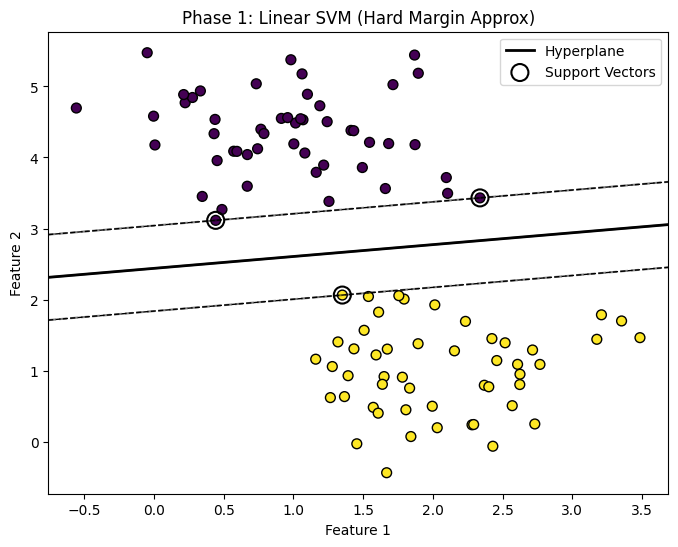


--- Phase 2: Soft Margin SVM (Effect of C) ---

C = 0.01
Number of support vectors: 58


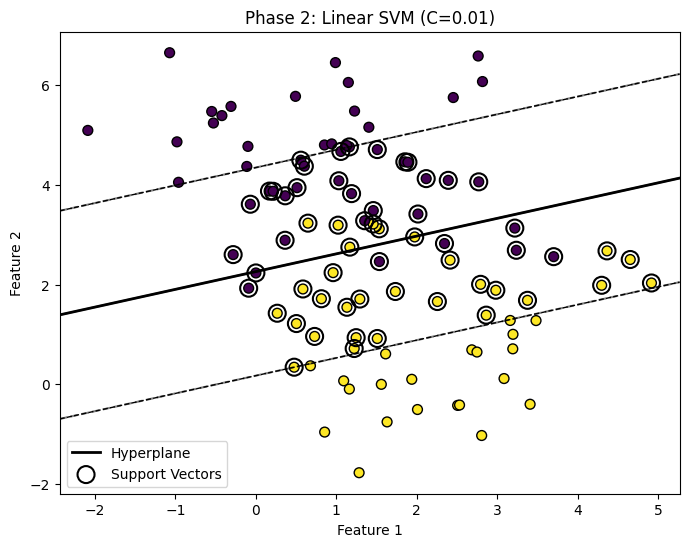


C = 1
Number of support vectors: 25


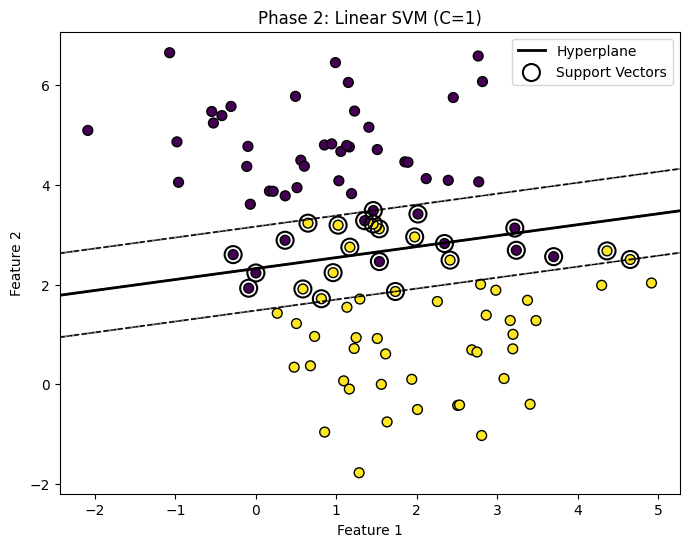


C = 100
Number of support vectors: 23


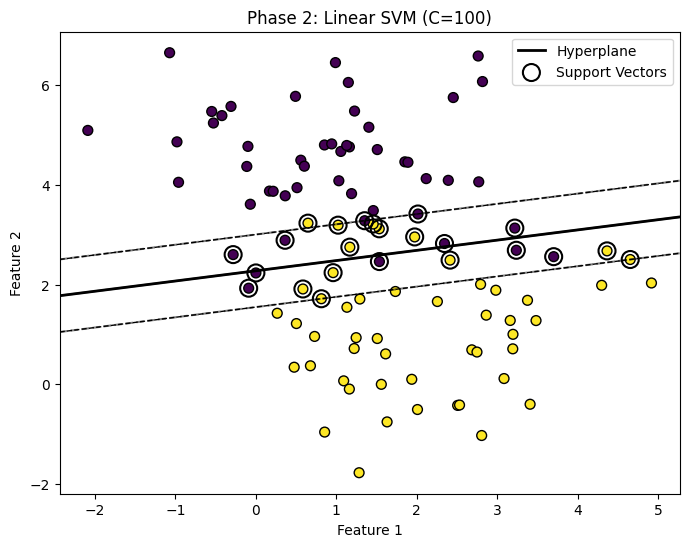


--- Phase 3: Non-Linear SVM (Kernel Trick) ---


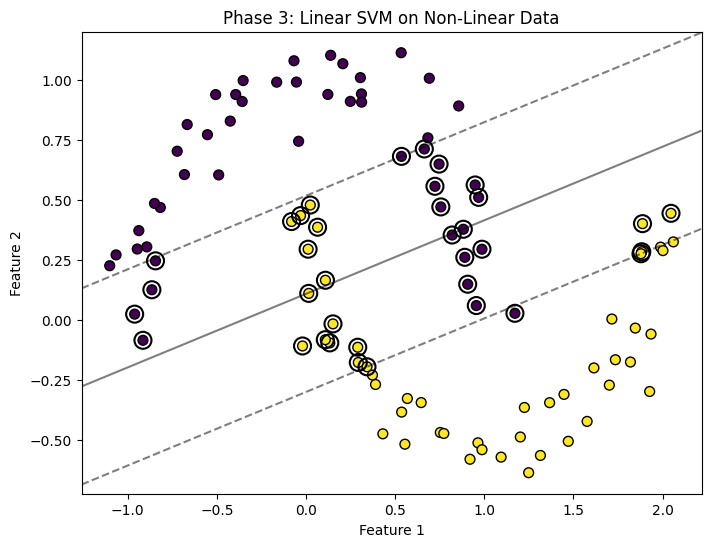

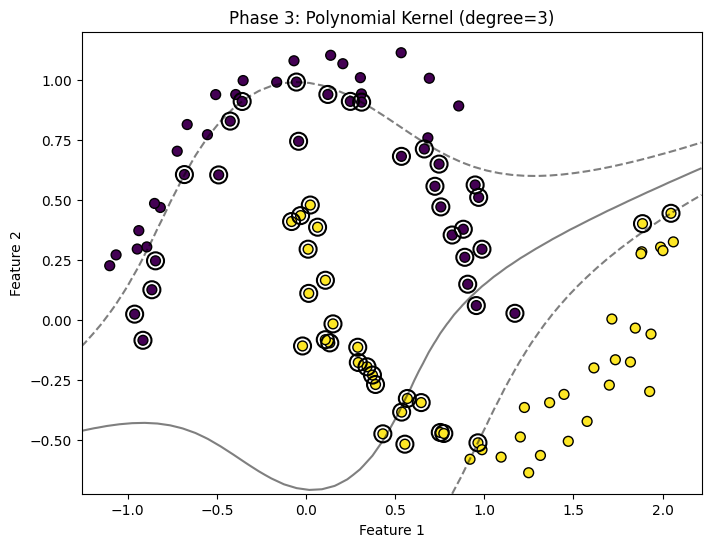

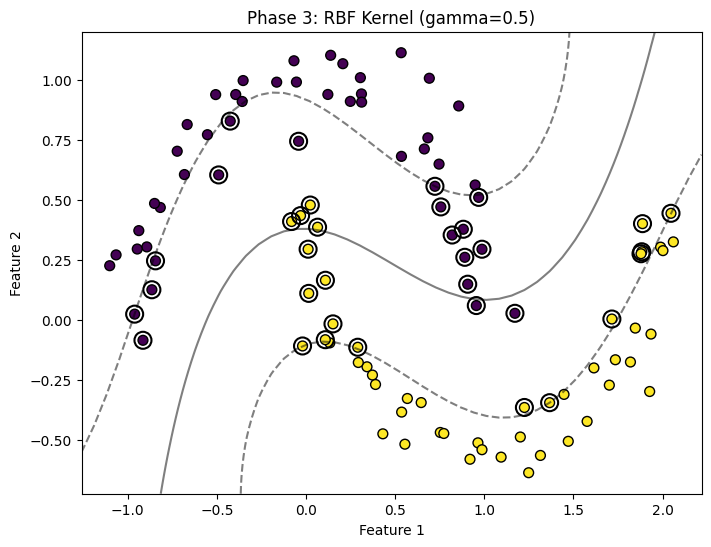


--- Phase 4: Effect of RBF Kernel Parameter (gamma) ---


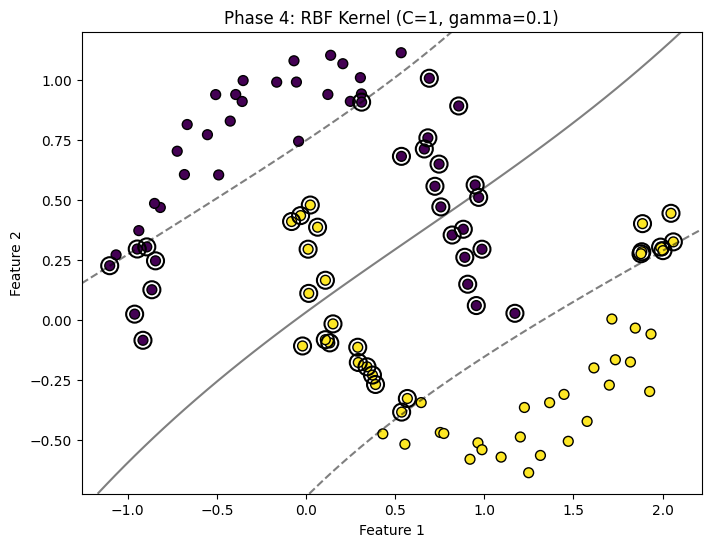

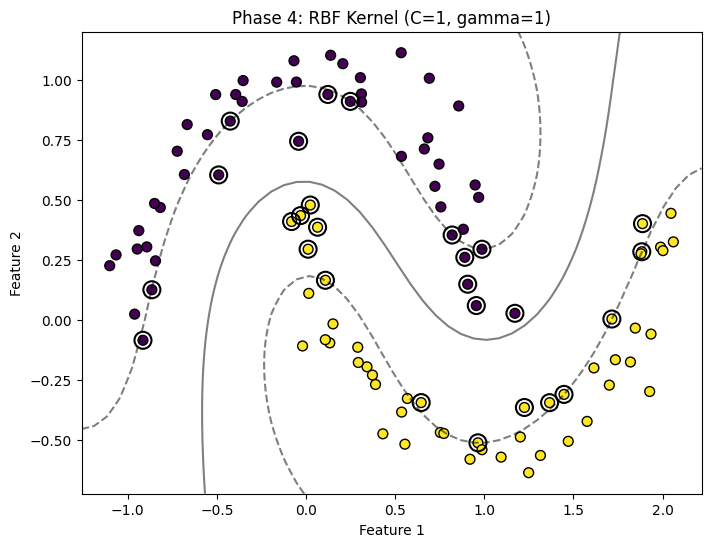

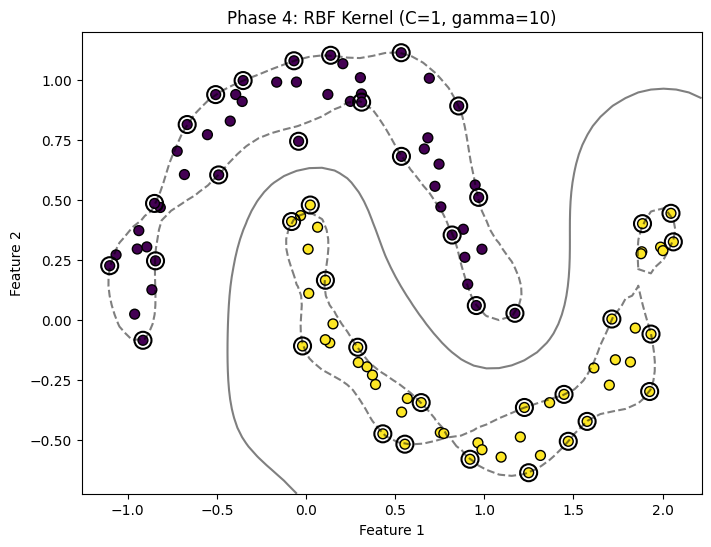

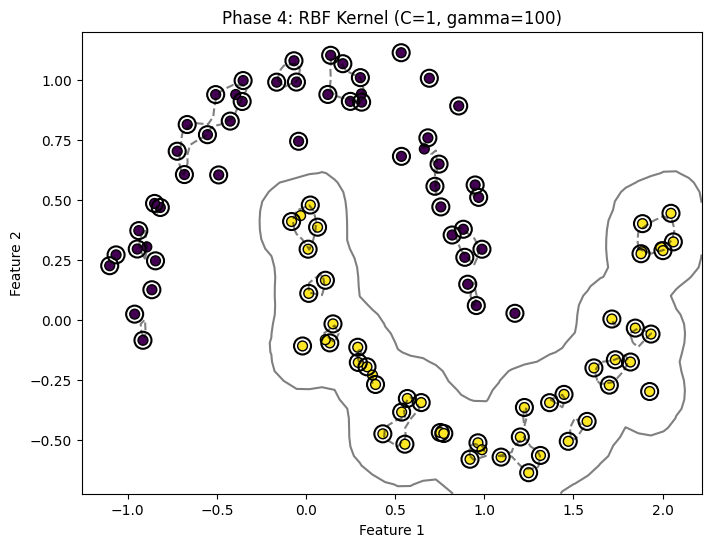


--- Phase 5: Importance of Feature Scaling ---


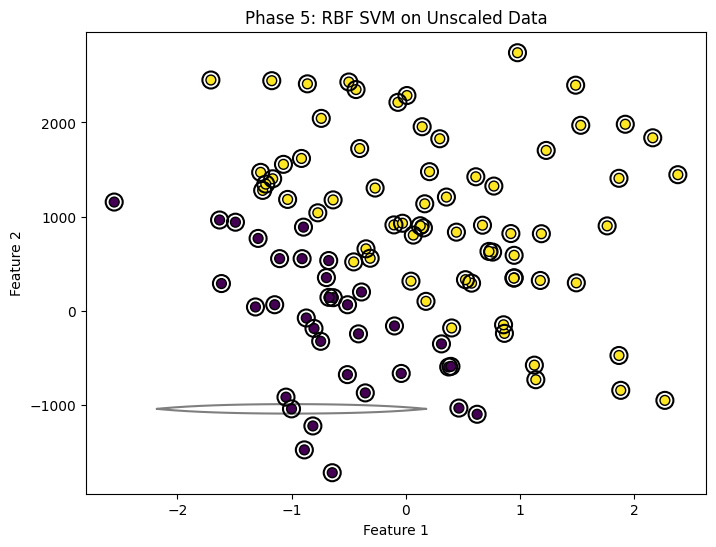

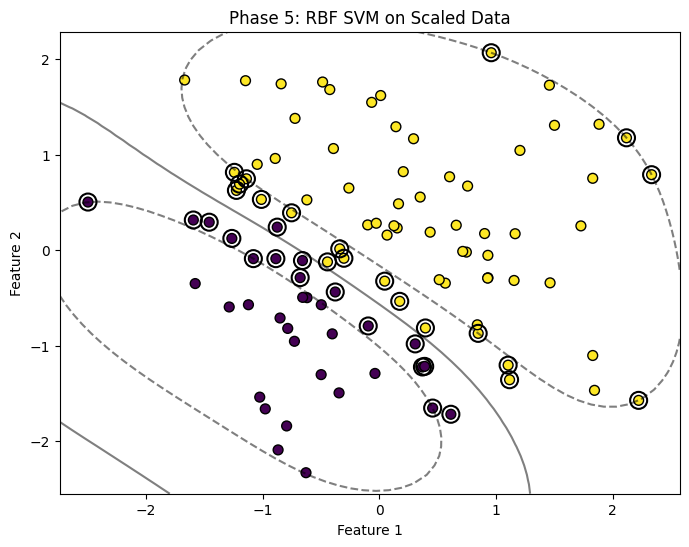


Experiment Complete!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Helper function to visualize the SVM decision boundary
def plot_svm_boundary(model, X, y, title="SVM Decision Boundary"):
    """Plots the decision boundary for a fitted SVM model."""
    plt.figure(figsize=(8, 6))

    # Scatter plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k')

    # Create grid to evaluate model
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Get the decision boundary (distance from hyperplane)
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        sv = model.support_vectors_
        ax.scatter(sv[:, 0], sv[:, 1], s=150, facecolors='none', edgecolors='k', linewidth=1.5)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

# Helper function specifically for LinearSVC or SVC(kernel='linear')
def plot_linear_svm_details(model, X, y, title="Linear SVM Details"):
    """Plots hyperplane, margins, and support vectors for linear SVM."""
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Plot the hyperplane (w.x + b = 0) using coefficients
    if hasattr(model, 'coef_') and hasattr(model, 'intercept_'):
        w = model.coef_[0]
        b = model.intercept_[0]
        # Line equation: w0*x0 + w1*x1 + b = 0 => x1 = (-w0*x0 - b) / w1
        if abs(w[1]) > 1e-6: # Avoid division by zero if w1 is tiny
            x0_plot = np.linspace(xlim[0], xlim[1], 30)
            x1_plot = (-w[0] * x0_plot - b) / w[1]
            # Plot only within the y-limits
            valid_indices = (x1_plot >= ylim[0]) & (x1_plot <= ylim[1])
            ax.plot(x0_plot[valid_indices], x1_plot[valid_indices], 'k-', linewidth=2, label='Hyperplane')

            # Plot margin lines (w.x + b = +/- 1)
            margin = 1 / np.sqrt(np.sum(model.coef_ ** 2)) # Margin width = 1 / ||w||
            x1_plot_m1 = x1_plot - np.sqrt(1 + (w[0]/w[1])**2) * margin
            x1_plot_p1 = x1_plot + np.sqrt(1 + (w[0]/w[1])**2) * margin
            ax.plot(x0_plot[valid_indices], x1_plot_m1[valid_indices], 'k--', linewidth=1)
            ax.plot(x0_plot[valid_indices], x1_plot_p1[valid_indices], 'k--', linewidth=1)
        else: # If w1 is close to zero, the line is nearly vertical
            x0_plot_val = -b / w[0]
            if xlim[0] <= x0_plot_val <= xlim[1]:
                 ax.axvline(x=x0_plot_val, color='k', linestyle='-', linewidth=2, label='Hyperplane')
                 margin = 1 / np.abs(w[0])
                 ax.axvline(x=x0_plot_val - margin, color='k', linestyle='--', linewidth=1)
                 ax.axvline(x=x0_plot_val + margin, color='k', linestyle='--', linewidth=1)


    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        sv = model.support_vectors_
        ax.scatter(sv[:, 0], sv[:, 1], s=150, facecolors='none', edgecolors='k', linewidth=1.5, label='Support Vectors')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()

print("--- Phase 1: Linear SVM on Linearly Separable Data ---")
# 1. Generate linearly separable data
X_linear, y_linear = make_blobs(n_samples=100, centers=2,
                                random_state=0, cluster_std=0.60)

# 2. Train a Linear SVM
#    Use SVC with linear kernel and a large C to approximate hard margin
#    Alternatively, use LinearSVC(C=1000, loss='hinge', max_iter=5000) - often faster for linear
linear_svm = svm.SVC(kernel='linear', C=1000)
linear_svm.fit(X_linear, y_linear)

# 3. Visualize
print(f"Number of support vectors: {len(linear_svm.support_vectors_)}")
print(f"Support vectors:\n{linear_svm.support_vectors_}")
print(f"Coefficients (w): {linear_svm.coef_}")
print(f"Intercept (b): {linear_svm.intercept_}")
plot_linear_svm_details(linear_svm, X_linear, y_linear, title="Phase 1: Linear SVM (Hard Margin Approx)")

# --- Observation Points ---
# - Notice the clear separating line (hyperplane).
# - Notice the dashed lines representing the margin.
# - Identify the points circled (support vectors). Observe they lie *on* the margin.
# - The decision boundary is determined *only* by these support vectors.

# --- --- ---

print("\n--- Phase 2: Soft Margin SVM (Effect of C) ---")
# 1. Generate data with some overlap
X_overlap, y_overlap = make_blobs(n_samples=100, centers=2,
                                  random_state=0, cluster_std=1.2)

# 2. Train SVMs with different C values
C_values = [0.01, 1, 100]
models_C = {}

for C_val in C_values:
    # Using SVC here, works well for visualization. LinearSVC is also an option.
    model = svm.SVC(kernel='linear', C=C_val)
    model.fit(X_overlap, y_overlap)
    models_C[C_val] = model
    print(f"\nC = {C_val}")
    print(f"Number of support vectors: {len(model.support_vectors_)}")
    # plot_svm_boundary(model, X_overlap, y_overlap, title=f"Phase 2: Linear SVM (C={C_val})")
    plot_linear_svm_details(model, X_overlap, y_overlap, title=f"Phase 2: Linear SVM (C={C_val})")


# --- Observation Points ---
# - Small C: Wider margin, allows more misclassifications (or points inside the margin). More regularization. The model is simpler.
# - Large C: Narrower margin, tries harder to classify points correctly, potentially leading to a more complex boundary (less regularization). Fewer points allowed inside margin/misclassified.
# - Observe how the number and position of support vectors change with C. With smaller C, more points might influence the margin.

# --- --- ---

print("\n--- Phase 3: Non-Linear SVM (Kernel Trick) ---")
# 1. Generate non-linearly separable data
X_nl, y_nl = make_moons(n_samples=100, noise=0.1, random_state=0)
# X_nl, y_nl = make_circles(n_samples=100, noise=0.05, factor=0.5, random_state=1) # Alternative dataset

# 2. Try Linear SVM (expected to fail)
linear_fail = svm.SVC(kernel='linear', C=1).fit(X_nl, y_nl)
plot_svm_boundary(linear_fail, X_nl, y_nl, title="Phase 3: Linear SVM on Non-Linear Data")

# 3. Try Non-Linear Kernels
# Polynomial Kernel
poly_svm = svm.SVC(kernel='poly', degree=3, C=1, gamma='auto').fit(X_nl, y_nl) # gamma='auto' uses 1/n_features
plot_svm_boundary(poly_svm, X_nl, y_nl, title="Phase 3: Polynomial Kernel (degree=3)")

# RBF Kernel
rbf_svm = svm.SVC(kernel='rbf', C=1, gamma=0.5).fit(X_nl, y_nl) # Try different gamma values
plot_svm_boundary(rbf_svm, X_nl, y_nl, title="Phase 3: RBF Kernel (gamma=0.5)")

# --- Observation Points ---
# - See how the linear kernel fails to separate the non-linear data effectively.
# - Observe the curved decision boundaries created by the polynomial and RBF kernels.
# - Understand that the kernel trick implicitly maps data to a higher dimension where it becomes (more) linearly separable, without explicitly computing the coordinates.

# --- --- ---

print("\n--- Phase 4: Effect of RBF Kernel Parameter (gamma) ---")
# Using the same non-linear data (moons)
gamma_values = [0.1, 1, 10, 100]
models_gamma = {}

for gamma_val in gamma_values:
    model = svm.SVC(kernel='rbf', C=1, gamma=gamma_val) # Keep C constant for now
    model.fit(X_nl, y_nl)
    models_gamma[gamma_val] = model
    plot_svm_boundary(model, X_nl, y_nl, title=f"Phase 4: RBF Kernel (C=1, gamma={gamma_val})")

# --- Observation Points ---
# - Small gamma: Large variance Gaussian -> Smooth decision boundary, broader influence of each point (can lead to underfitting).
# - Large gamma: Small variance Gaussian -> Complex, wiggly decision boundary, influence of each point is very local (can lead to overfitting). Each support vector strongly influences only its immediate vicinity.
# - Gamma acts as an inverse radius of influence for samples selected as support vectors.
# - Try changing C along with gamma (e.g., large C and large gamma) to see overfitting potential.

# --- --- ---

print("\n--- Phase 5: Importance of Feature Scaling ---")
# 1. Create data with vastly different scales
rng = np.random.RandomState(0)
X_unscaled = rng.randn(100, 2)
X_unscaled[:, 1] = X_unscaled[:, 1] * 1000 + 500 # Make feature 2 have a much larger scale
y_unscaled = (X_unscaled[:, 0] + X_unscaled[:, 1] * 0.001 > 0).astype(int) # Simple linear boundary based on combination

# 2. Train SVM on unscaled data (RBF kernel is sensitive)
svm_unscaled = svm.SVC(kernel='rbf', C=1, gamma='auto').fit(X_unscaled, y_unscaled)
plot_svm_boundary(svm_unscaled, X_unscaled, y_unscaled, title="Phase 5: RBF SVM on Unscaled Data")

# 3. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unscaled)

# 4. Train SVM on scaled data
svm_scaled = svm.SVC(kernel='rbf', C=1, gamma='auto').fit(X_scaled, y_unscaled) # Use the same y!
plot_svm_boundary(svm_scaled, X_scaled, y_unscaled, title="Phase 5: RBF SVM on Scaled Data")


# --- Observation Points ---
# - Look at the decision boundary on the unscaled data. It might look squashed or perform poorly because the RBF kernel (and linear kernel distance calculations) are sensitive to feature ranges. The feature with the larger range (Feature 2) will dominate distance calculations.
# - Observe the decision boundary on the scaled data. It should look more reasonable and likely perform better (though performance isn't explicitly measured here, the boundary shape reflects effectiveness).
# - Understand that SVMs (especially with kernels like RBF) assume features are roughly centered around 0 and have similar variance. Scaling ensures all features contribute more equally.

# --- --- ---

print("\nExperiment Complete!")


--- Phase 6: Linear SVM in 3D ---
Number of support vectors (3D): 2
Coefficients (w) (3D): [[-0.06851147 -0.24998442  0.02300736]]
Intercept (b) (3D): [-0.25897325]


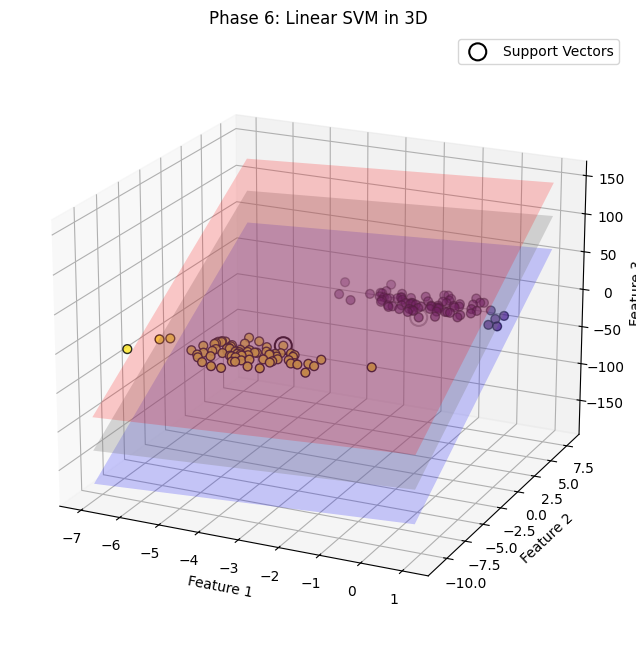


Training RBF SVM in 3D (Visualization limited)
Number of support vectors (RBF 3D): 17


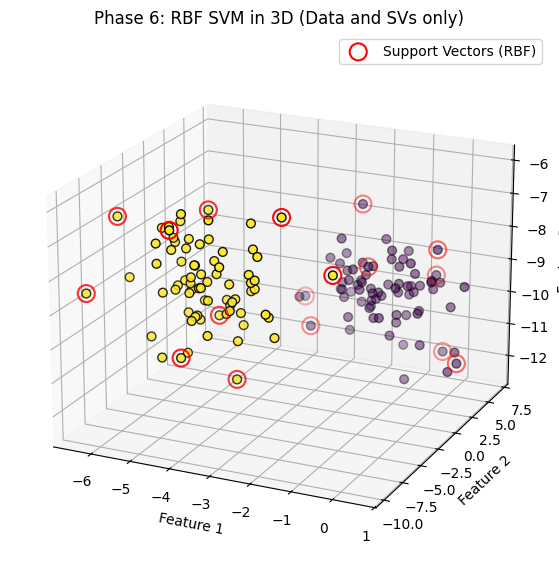


--- Phase 7: SVM in Higher Dimensions (>3D) ---

Training on Unscaled vs Scaled Data (10 dimensions)
Accuracy (Unscaled Data): 1.0000
Support Vector Ratio (Unscaled): 0.0524
Accuracy (Scaled Data):   1.0000
Support Vector Ratio (Scaled):   0.1905
Accuracy (Linear, Unscaled): 1.0000
Accuracy (Linear, Scaled):   1.0000

Exploring C and Gamma (10 dimensions, Scaled Data)
C=0.1, gamma=0.01: Accuracy=1.0000, SV Ratio=0.6190
C=0.1, gamma=0.1: Accuracy=1.0000, SV Ratio=0.3952
C=0.1, gamma=1: Accuracy=0.4556, SV Ratio=0.9857
C=0.1, gamma=10: Accuracy=0.4556, SV Ratio=1.0000
C=0.1, gamma=scale: Accuracy=1.0000, SV Ratio=0.3952
C=1, gamma=0.01: Accuracy=1.0000, SV Ratio=0.1333
C=1, gamma=0.1: Accuracy=1.0000, SV Ratio=0.1905
C=1, gamma=1: Accuracy=0.9778, SV Ratio=0.9714
C=1, gamma=10: Accuracy=0.4556, SV Ratio=1.0000
C=1, gamma=scale: Accuracy=1.0000, SV Ratio=0.1905
C=10, gamma=0.01: Accuracy=1.0000, SV Ratio=0.0381
C=10, gamma=0.1: Accuracy=1.0000, SV Ratio=0.1857
C=10, gamma=1: Accuracy=0.9

In [2]:
# --- Previous Code (Phases 1-5) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Import 3D plotting tool
from mpl_toolkits.mplot3d import Axes3D

# --- Helper functions from previous code (plot_svm_boundary, plot_linear_svm_details) ---
# (Assume they are defined as in the previous response)
# Helper function to visualize the SVM decision boundary (2D)
def plot_svm_boundary(model, X, y, title="SVM Decision Boundary"):
    """Plots the decision boundary for a fitted SVM model."""
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 50)
    yy = np.linspace(ylim[0], ylim[1], 50)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    if hasattr(model, 'support_vectors_') and model.support_vectors_.shape[1] == 2: # Only plot SVs if they are 2D
        sv = model.support_vectors_
        ax.scatter(sv[:, 0], sv[:, 1], s=150, facecolors='none', edgecolors='k', linewidth=1.5)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

# Helper function specifically for LinearSVC or SVC(kernel='linear') (2D)
def plot_linear_svm_details(model, X, y, title="Linear SVM Details"):
    """Plots hyperplane, margins, and support vectors for linear SVM."""
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis', edgecolors='k')
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    if hasattr(model, 'coef_') and hasattr(model, 'intercept_'):
        w = model.coef_[0]
        b = model.intercept_[0]
        if abs(w[1]) > 1e-6:
            x0_plot = np.linspace(xlim[0], xlim[1], 30)
            x1_plot = (-w[0] * x0_plot - b) / w[1]
            valid_indices = (x1_plot >= ylim[0]) & (x1_plot <= ylim[1])
            ax.plot(x0_plot[valid_indices], x1_plot[valid_indices], 'k-', linewidth=2, label='Hyperplane')
            margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
            x1_plot_m1 = x1_plot - np.sqrt(1 + (w[0]/w[1])**2) * margin
            x1_plot_p1 = x1_plot + np.sqrt(1 + (w[0]/w[1])**2) * margin
            ax.plot(x0_plot[valid_indices], x1_plot_m1[valid_indices], 'k--', linewidth=1)
            ax.plot(x0_plot[valid_indices], x1_plot_p1[valid_indices], 'k--', linewidth=1)
        else:
            x0_plot_val = -b / w[0]
            if xlim[0] <= x0_plot_val <= xlim[1]:
                 ax.axvline(x=x0_plot_val, color='k', linestyle='-', linewidth=2, label='Hyperplane')
                 margin = 1 / np.abs(w[0])
                 ax.axvline(x=x0_plot_val - margin, color='k', linestyle='--', linewidth=1)
                 ax.axvline(x=x0_plot_val + margin, color='k', linestyle='--', linewidth=1)
    if hasattr(model, 'support_vectors_') and model.support_vectors_.shape[1] == 2:
        sv = model.support_vectors_
        ax.scatter(sv[:, 0], sv[:, 1], s=150, facecolors='none', edgecolors='k', linewidth=1.5, label='Support Vectors')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.show()
# --- End of previously defined helpers ---


# Helper function to plot 3D data and linear SVM plane
def plot_svm_3d(model, X, y, title="3D SVM Visualization"):
    """Plots 3D data points and the linear SVM decision plane."""
    if X.shape[1] != 3:
        print("Error: Data must have 3 features for 3D plotting.")
        return
    if not (hasattr(model, 'coef_') and hasattr(model, 'intercept_')):
         print("Error: Model must be linear (or kernel='linear') with coef_ and intercept_ for plane plotting.")
         # Optional: Could just plot points if model isn't linear
         # fig = plt.figure(figsize=(9, 7))
         # ax = fig.add_subplot(111, projection='3d')
         # ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=40, cmap='viridis', edgecolors='k')
         # ax.set_title(title + " (Data Only)")
         # ax.set_xlabel("Feature 1")
         # ax.set_ylabel("Feature 2")
         # ax.set_zlabel("Feature 3")
         # plt.show()
         return

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot the data points
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=40, cmap='viridis', edgecolors='k', depthshade=True)

    # Create a grid for the plane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10),
                         np.linspace(ylim[0], ylim[1], 10))

    # Get coefficients (w) and intercept (b)
    w = model.coef_[0]
    b = model.intercept_[0]

    # Plane equation: w0*x + w1*y + w2*z + b = 0
    # Solve for z: z = (-w0*x - w1*y - b) / w2
    if abs(w[2]) > 1e-6: # Avoid division by zero if w2 is tiny
        zz = (-w[0] * xx - w[1] * yy - b) / w[2]
        # Plot the plane surface
        ax.plot_surface(xx, yy, zz, alpha=0.3, color='gray', rstride=100, cstride=100, shade=False) # Use shade=False for uniform color

        # Plot margin planes: w.x + b = +/- 1
        margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
        # Offset the plane equation z solution by the margin component in z direction
        # A better way: Calculate point on plane (x,y,z) and normal vector w. Move point along normal by +/- margin dist.
        # Simplified for visualization: calculate z offset for margins (less accurate geometrically but shows separation)
        zz_m1 = (-w[0] * xx - w[1] * yy - b - 1) / w[2]
        zz_p1 = (-w[0] * xx - w[1] * yy - b + 1) / w[2]
        ax.plot_surface(xx, yy, zz_m1, alpha=0.2, color='blue', rstride=100, cstride=100, shade=False)
        ax.plot_surface(xx, yy, zz_p1, alpha=0.2, color='red', rstride=100, cstride=100, shade=False)

    else: # If w[2] is near zero, the plane is (almost) vertical (parallel to z-axis)
        # Equation becomes: w0*x + w1*y + b = 0. This defines a line in xy plane, extruded vertically.
        # We can't easily plot an infinite vertical plane with plot_surface.
        # Alternative: plot contour in xy plane? Or skip plane visualization for this edge case.
        print("Warning: Decision plane is nearly vertical (coefficient for Z is close to 0). Plane visualization skipped.")
        # Optional: Add contour plot on the xy plane at z=0 or similar
        # Z_contour = w[0] * xx + w[1] * yy + b
        # ax.contour(xx, yy, Z_contour, levels=[0], colors='k', linestyles='-') # Won't show in 3D plot view correctly

    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        sv = model.support_vectors_
        ax.scatter(sv[:, 0], sv[:, 1], sv[:, 2], s=150, facecolors='none', edgecolors='k', linewidth=1.5, label='Support Vectors')

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    ax.set_title(title)
    # Improve view angle for better perspective
    ax.view_init(elev=20., azim=-65)
    plt.legend()
    plt.show()


# --- Run Previous Phases (Optional) ---
# print("--- Running Phases 1-5 ---")
# exec(open("previous_svm_script.py").read()) # If you saved the previous code
# Or just paste the code for phases 1-5 here if needed
# ... (Code from phases 1-5) ...

print("\n--- Phase 6: Linear SVM in 3D ---")
# 1. Generate 3D linearly separable data
X_3d, y_3d = make_blobs(n_samples=150, centers=2, n_features=3,
                        random_state=1, cluster_std=1.0)

# 2. Train a Linear SVM
linear_svm_3d = svm.SVC(kernel='linear', C=1.0)
linear_svm_3d.fit(X_3d, y_3d)

# 3. Visualize
print(f"Number of support vectors (3D): {len(linear_svm_3d.support_vectors_)}")
print(f"Coefficients (w) (3D): {linear_svm_3d.coef_}")
print(f"Intercept (b) (3D): {linear_svm_3d.intercept_}")

# Plotting
plot_svm_3d(linear_svm_3d, X_3d, y_3d, title="Phase 6: Linear SVM in 3D")

# 4. (Optional) Try RBF kernel in 3D - Can't easily plot the curved boundary
rbf_svm_3d = svm.SVC(kernel='rbf', C=1.0, gamma=0.1) # Gamma needs tuning based on data scale
rbf_svm_3d.fit(X_3d, y_3d)
print(f"\nTraining RBF SVM in 3D (Visualization limited)")
print(f"Number of support vectors (RBF 3D): {len(rbf_svm_3d.support_vectors_)}")

# We can still plot the points and SVs for the RBF case
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y_3d, s=40, cmap='viridis', edgecolors='k', depthshade=True)
sv_rbf = rbf_svm_3d.support_vectors_
ax.scatter(sv_rbf[:, 0], sv_rbf[:, 1], sv_rbf[:, 2], s=150, facecolors='none', edgecolors='r', linewidth=1.5, label='Support Vectors (RBF)')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Phase 6: RBF SVM in 3D (Data and SVs only)")
ax.view_init(elev=20., azim=-65)
plt.legend()
plt.show()


# --- Observation Points (Phase 6) ---
# - Observe the separating *plane* for the linear SVM in 3D space.
# - Notice the margin planes parallel to the decision plane.
# - Identify the support vectors (circled points), which lie on or within the margins and define the plane's position and orientation.
# - Realize that plotting the non-linear (e.g., RBF) decision boundary surface is much harder, though the concept is the same (a separating surface). We can still plot the data and SVs.

# --- --- ---

print("\n--- Phase 7: SVM in Higher Dimensions (>3D) ---")
# Since we can't visualize, we rely on metrics and understanding parameter effects.

# 1. Generate higher-dimensional data (e.g., 10 features)
N_FEATURES = 10
X_high_d, y_high_d = make_blobs(n_samples=300, centers=2, n_features=N_FEATURES,
                                random_state=42, cluster_std=1.5)

# 2. Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_high_d, y_high_d, test_size=0.3, random_state=42)

# 3. Importance of Scaling (Demonstration)
#   a) Train on unscaled data
scaler_hd = StandardScaler()
X_train_scaled = scaler_hd.fit_transform(X_train)
X_test_scaled = scaler_hd.transform(X_test) # Use transform, not fit_transform on test data!

print("\nTraining on Unscaled vs Scaled Data ({} dimensions)".format(N_FEATURES))

# Unscaled
svm_unscaled_hd = svm.SVC(kernel='rbf', C=1.0, gamma='scale') # gamma='scale' is often a good default
svm_unscaled_hd.fit(X_train, y_train)
y_pred_unscaled = svm_unscaled_hd.predict(X_test)
acc_unscaled = accuracy_score(y_test, y_pred_unscaled)
sv_unscaled_ratio = len(svm_unscaled_hd.support_vectors_) / len(X_train)
print(f"Accuracy (Unscaled Data): {acc_unscaled:.4f}")
print(f"Support Vector Ratio (Unscaled): {sv_unscaled_ratio:.4f}")

# Scaled
svm_scaled_hd = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
svm_scaled_hd.fit(X_train_scaled, y_train)
y_pred_scaled = svm_scaled_hd.predict(X_test_scaled)
acc_scaled = accuracy_score(y_test, y_pred_scaled)
sv_scaled_ratio = len(svm_scaled_hd.support_vectors_) / len(X_train_scaled)
print(f"Accuracy (Scaled Data):   {acc_scaled:.4f}")
print(f"Support Vector Ratio (Scaled):   {sv_scaled_ratio:.4f}")

#   b) Try Linear SVM as well (less sensitive to scaling, but still good practice)
svm_linear_unscaled_hd = svm.SVC(kernel='linear', C=1.0)
svm_linear_unscaled_hd.fit(X_train, y_train)
y_pred_linear_unscaled = svm_linear_unscaled_hd.predict(X_test)
acc_linear_unscaled = accuracy_score(y_test, y_pred_linear_unscaled)
print(f"Accuracy (Linear, Unscaled): {acc_linear_unscaled:.4f}")

svm_linear_scaled_hd = svm.SVC(kernel='linear', C=1.0)
svm_linear_scaled_hd.fit(X_train_scaled, y_train)
y_pred_linear_scaled = svm_linear_scaled_hd.predict(X_test_scaled)
acc_linear_scaled = accuracy_score(y_test, y_pred_linear_scaled)
print(f"Accuracy (Linear, Scaled):   {acc_linear_scaled:.4f}")


# 4. Effect of C and Gamma in High Dimensions (using scaled data)
print("\nExploring C and Gamma ({} dimensions, Scaled Data)".format(N_FEATURES))
C_vals_hd = [0.1, 1, 10, 100]
gamma_vals_hd = [0.01, 0.1, 1, 10, 'scale'] # 'scale' = 1 / (n_features * X.var())

for C_val in C_vals_hd:
    for gamma_val in gamma_vals_hd:
        model = svm.SVC(kernel='rbf', C=C_val, gamma=gamma_val)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        sv_ratio = len(model.support_vectors_) / len(X_train_scaled)
        print(f"C={C_val}, gamma={gamma_val}: Accuracy={acc:.4f}, SV Ratio={sv_ratio:.4f}")


# --- Observation Points (Phase 7) ---
# - Scaling: Observe the potentially significant difference in accuracy (especially for RBF) between using scaled and unscaled data in higher dimensions. Scaling becomes even more critical as the 'curse of dimensionality' can exacerbate differences in feature scales.
# - C and Gamma: Analyze the accuracy results for different combinations.
#     - Low C might underfit (lower accuracy, possibly higher SV ratio as margin is wide).
#     - High C might overfit (potentially high accuracy on train, maybe lower on test, often lower SV ratio as margin is tight).
#     - Low gamma (like 'scale' or small values) gives smoother boundaries (might underfit if too low).
#     - High gamma gives very complex boundaries focused on individual points (likely to overfit, high accuracy only if data is very clean, SV ratio might increase as many points become influential locally).
# - Support Vector Ratio: Note how the fraction of training points that become support vectors changes with C and gamma. A very high ratio (close to 1.0) can sometimes indicate overfitting or that the data is difficult to separate with the chosen kernel/parameters. A very low ratio suggests a potentially cleaner separation.
# - No Visualization: Acknowledge that we are now relying purely on metrics (accuracy) and SV counts to understand and tune the model's behavior in this high-dimensional space. Cross-validation would typically be used for robust parameter tuning in a real scenario.

# --- --- ---

print("\nExperiment Complete (Including 3D and High-Dimensional aspects)!")

--- Loading and Preparing Data ---
Dataset shape: (569, 30)
Number of features: 30
Target classes: ['malignant' 'benign'] ([212 357])
Training set size: 398
Test set size: 171
Data Scaling Complete.

--- Experiment 1: Linear SVM with varying C ---

Training Linear SVM with C = 0.001
  Test Accuracy: 0.9415
  Number of Support Vectors: 191 (Ratio: 0.480)
  Training Time: 0.0083 seconds

Training Linear SVM with C = 0.01
  Test Accuracy: 0.9591
  Number of Support Vectors: 91 (Ratio: 0.229)
  Training Time: 0.0056 seconds

Training Linear SVM with C = 0.1
  Test Accuracy: 0.9708
  Number of Support Vectors: 42 (Ratio: 0.106)
  Training Time: 0.0067 seconds

Training Linear SVM with C = 1
  Test Accuracy: 0.9825
  Number of Support Vectors: 31 (Ratio: 0.078)
  Training Time: 0.0057 seconds

Training Linear SVM with C = 10
  Test Accuracy: 0.9532
  Number of Support Vectors: 25 (Ratio: 0.063)
  Training Time: 0.0104 seconds

Training Linear SVM with C = 100
  Test Accuracy: 0.9415
  Number

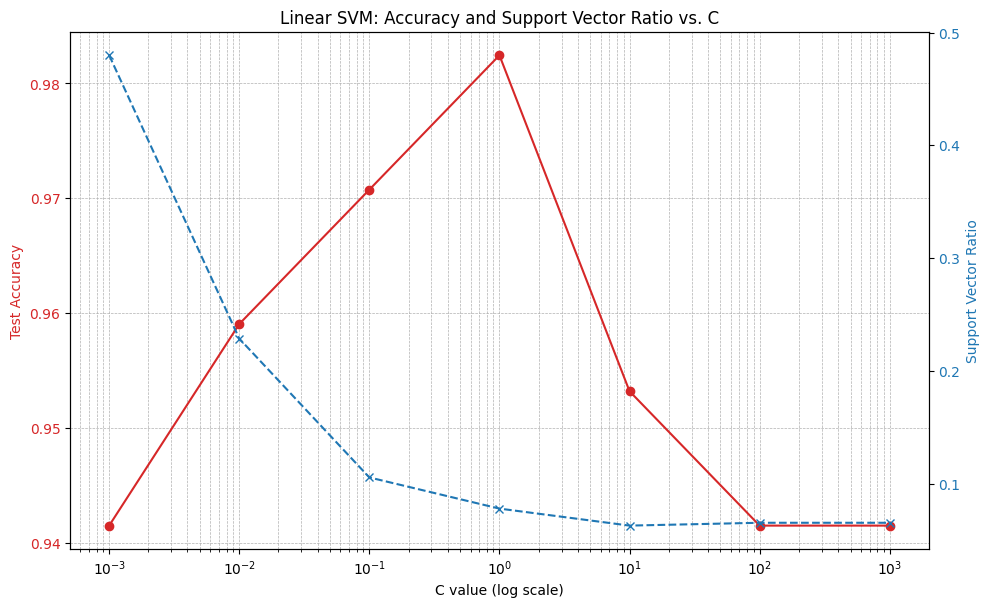


--- Experiment 2: RBF Kernel SVM with varying C and gamma ---

Training RBF SVM with C = 0.1, gamma = 0.001
  Test Accuracy: 0.7544
  Number of Support Vectors: 294 (Ratio: 0.739)
  Training Time: 0.0135 seconds

Training RBF SVM with C = 0.1, gamma = 0.01
  Test Accuracy: 0.9415
  Number of Support Vectors: 182 (Ratio: 0.457)
  Training Time: 0.0055 seconds

Training RBF SVM with C = 0.1, gamma = 0.1
  Test Accuracy: 0.9415
  Number of Support Vectors: 267 (Ratio: 0.671)
  Training Time: 0.0077 seconds

Training RBF SVM with C = 0.1, gamma = 1
  Test Accuracy: 0.6257
  Number of Support Vectors: 398 (Ratio: 1.000)
  Training Time: 0.0116 seconds

Training RBF SVM with C = 0.1, gamma = 10
  Test Accuracy: 0.6257
  Number of Support Vectors: 398 (Ratio: 1.000)
  Training Time: 0.0143 seconds

Training RBF SVM with C = 0.1, gamma = scale
  Test Accuracy: 0.9357
  Number of Support Vectors: 183 (Ratio: 0.460)
  Training Time: 0.0058 seconds

Training RBF SVM with C = 0.1, gamma = auto
  

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score
import time # To time the training

print("--- Loading and Preparing Data ---")

# 1. Load Dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names
target_names = cancer.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Target classes: {target_names} ({np.bincount(y)})")

# 2. Split Data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 3. Scale Features
#    SVMs are sensitive to feature scaling!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # IMPORTANT: Use transform, not fit_transform, on test data

print("Data Scaling Complete.")

# --- --- ---

print("\n--- Experiment 1: Linear SVM with varying C ---")

C_values_linear = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
linear_results = {'C': [], 'Accuracy': [], 'SV Ratio': [], 'Train Time': []}

for C_val in C_values_linear:
    print(f"\nTraining Linear SVM with C = {C_val}")
    start_time = time.time()

    # Use SVC(kernel='linear') - generally good, can be slow on very large datasets
    # Alternatively, could use svm.LinearSVC(C=C_val, max_iter=5000, dual=False) - often faster for linear
    # Note: LinearSVC might give slightly different results due to different implementation/optimization
    model = svm.SVC(kernel='linear', C=C_val, random_state=42)
    model.fit(X_train_scaled, y_train)

    end_time = time.time()
    train_time = end_time - start_time

    # Evaluate on the TEST set
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    # Get support vectors
    n_sv = len(model.support_vectors_)
    sv_ratio = n_sv / X_train_scaled.shape[0] # Ratio relative to training set size

    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Number of Support Vectors: {n_sv} (Ratio: {sv_ratio:.3f})")
    print(f"  Training Time: {train_time:.4f} seconds")

    linear_results['C'].append(C_val)
    linear_results['Accuracy'].append(accuracy)
    linear_results['SV Ratio'].append(sv_ratio)
    linear_results['Train Time'].append(train_time)

# Plotting Linear Results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('C value (log scale)')
ax1.set_ylabel('Test Accuracy', color=color)
ax1.semilogx(linear_results['C'], linear_results['Accuracy'], color=color, marker='o', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Support Vector Ratio', color=color)  # we already handled the x-label with ax1
ax2.semilogx(linear_results['C'], linear_results['SV Ratio'], color=color, marker='x', linestyle='--', label='SV Ratio')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Linear SVM: Accuracy and Support Vector Ratio vs. C')
plt.show()


# --- Observation Points (Linear SVM) ---
# - Accuracy: How does accuracy change with C? Often, it increases initially as C increases (allowing less regularization, fitting the data more closely) and then might plateau or even slightly decrease if C becomes too large for the noise level.
# - Support Vectors: Observe the trend in the number/ratio of SVs. Typically, very small C leads to a wider margin and potentially more SVs (as more points influence the wide margin). As C increases, the margin narrows, and fewer points might act as SVs (often those closest to the boundary or misclassified). A very large C might try to fit noisy points perfectly, potentially increasing SVs again in some cases.
# - Trade-off: `C` controls the trade-off between maximizing the margin (simpler model, more regularization - low C) and minimizing classification errors on the training set (more complex model, less regularization - high C).

# --- --- ---

print("\n--- Experiment 2: RBF Kernel SVM with varying C and gamma ---")

C_values_rbf = [0.1, 1, 10, 100]
# Common gamma choices: small, medium, large values + 'auto'/'scale'
# 'scale' = 1 / (n_features * X.var()) - often recommended default
# 'auto' = 1 / n_features
gamma_values_rbf = [0.001, 0.01, 0.1, 1, 10, 'scale', 'auto']

rbf_results = {} # Store results as: {(C, gamma): {'Accuracy': ..., 'SV Ratio': ...}}

best_accuracy = 0
best_params = {}

for C_val in C_values_rbf:
    for gamma_val in gamma_values_rbf:
        print(f"\nTraining RBF SVM with C = {C_val}, gamma = {gamma_val}")
        start_time = time.time()

        model = svm.SVC(kernel='rbf', C=C_val, gamma=gamma_val, random_state=42)
        model.fit(X_train_scaled, y_train)

        end_time = time.time()
        train_time = end_time - start_time

        # Evaluate on the TEST set
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        # Get support vectors
        n_sv = len(model.support_vectors_)
        sv_ratio = n_sv / X_train_scaled.shape[0]

        print(f"  Test Accuracy: {accuracy:.4f}")
        print(f"  Number of Support Vectors: {n_sv} (Ratio: {sv_ratio:.3f})")
        print(f"  Training Time: {train_time:.4f} seconds")

        rbf_results[(C_val, gamma_val)] = {'Accuracy': accuracy, 'SV Ratio': sv_ratio, 'Train Time': train_time}

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'C': C_val, 'gamma': gamma_val}

print("\n--- RBF SVM Results Summary ---")
print(f"Best Test Accuracy: {best_accuracy:.4f} achieved with parameters: {best_params}")

# You could add more sophisticated plotting here, e.g., a heatmap of accuracy vs C and gamma
# For simplicity, we'll just print the best result.

# --- Observation Points (RBF SVM) ---
# - Interaction: C and gamma interact significantly.
#   - High C + High gamma: Prone to overfitting. The model tries very hard to classify each point correctly (high C) using a very localized influence (high gamma). Accuracy might be high only if the test data is very similar to train data; SV ratio might be high.
#   - Low C + Low gamma: Prone to underfitting. The model is heavily regularized (low C) and uses a very broad influence (low gamma), leading to an overly smooth, potentially inaccurate boundary. SV ratio might be high as many points influence the wide, smooth boundary.
#   - Finding the Balance: The best performance usually lies somewhere in between, balancing the regularization strength (C) and the kernel's flexibility/locality (gamma). 'scale' or 'auto' for gamma are often reasonable starting points.
# - Comparison to Linear: Compare the best RBF accuracy to the best Linear SVM accuracy. Can the non-linear kernel capture patterns that the linear one missed? Sometimes yes, sometimes the data is sufficiently linearly separable (or close enough) that the linear kernel performs just as well or better (and is often faster/simpler).
# - SV Ratio: How does the SV ratio change with C and gamma? High gamma tends to make more points potential SVs as the influence becomes very local.

# --- --- ---

print("\nExperiment Complete.")
print("Key takeaways:")
print("1. Feature scaling is crucial for SVM performance, especially with RBF kernels.")
print("2. 'C' controls the regularization strength (margin width vs. classification errors).")
print("3. For RBF kernels, 'gamma' controls the influence radius of support vectors (boundary flexibility).")
print("4. Finding optimal C and gamma often requires searching (e.g., using GridSearchCV in practice).")
print("5. Performance must be evaluated on unseen test data.")
print("6. In high dimensions, metrics (accuracy, SV ratio) replace direct boundary visualization.")